In [28]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IA.utils import mapping, parameter_range
from scipy import stats
import math
import swifter
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science'])

In [2]:
!ls -lah analysis/not_uploaded/IA/ | grep scores-one
!ls -lah analysis/not_uploaded/IA/ | grep scores-three

-rw-r--r-- 1 janpf janpf 712M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-one.change_class.epoch-5.pth.txt
-rw-r--r-- 1 janpf janpf 952M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-one.change_regress.epoch-17.pth.txt
-rw-r--r-- 1 janpf janpf 936M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-one.change_regress.epoch-5.pth.txt
-rw-r--r-- 1 janpf janpf 935M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-one.change_regress.epoch-9.pth.txt
-rw-r--r-- 1 janpf janpf 153M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-one.epoch-1.pth.txt
-rw-r--r-- 1 janpf janpf 154M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-one.epoch-13.pth.txt
-rw-r--r-- 1 janpf janpf 836M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-three.change_class.epoch-1.pth.txt
-rw-r--r-- 1 janpf janpf 771M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-three.change_class.epoch-16.pth.txt
-rw-r--r-- 1 janpf janpf 235M Nov  6 21:07 .scratch.ckpts.IA.pexels.scores-three.epoch-1.pth.txt


In [37]:
df_one = pd.read_csv("analysis/not_uploaded/IA/.scratch.ckpts.IA.pexels.scores-one.epoch-13.pth.txt")
df_one_class = pd.read_csv("analysis/not_uploaded/IA/.scratch.ckpts.IA.pexels.scores-one.change_class.epoch-5.pth.txt")[["img", "distortion", "level", "score"]]
df_one_regr = pd.read_csv("analysis/not_uploaded/IA/.scratch.ckpts.IA.pexels.scores-one.change_regress.epoch-9.pth.txt")[["img", "distortion", "level", "score"]]

In [38]:
for df in [df_one, df_one_class, df_one_regr]:
    for col in df.columns:
        if not "score" in col:
            continue

        df[col] = df[col].swifter.apply(lambda row: eval(row)[0])

df_one = df_one.rename(columns={"score": "score_one"})
df_one_class = df_one_class.rename(columns={"score": "score_class"})
df_one_regr = df_one_regr.rename(columns={"score": "score_regr"})

df_one = df_one.set_index(["img", "distortion", "level"])
df_one_class = df_one_class.set_index(["img", "distortion", "level"])
df_one_regr = df_one_regr.set_index(["img", "distortion", "level"])

df = df_one.join([df_one_class, df_one_regr])
df = df.drop_duplicates()
df = df.dropna()

del df_one
del df_one_class
del df_one_regr

df = df.reset_index()
df

Pandas Apply: 100%|██████████| 2610000/2610000 [00:29<00:00, 89183.41it/s]


,img,distortion,level,score_one,score_class,score_regr
0,0/0/0/pexels-photo-1105376.jpeg,brightness,-1.0,0.233765,0.523438,0.020447
1,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.8,0.239502,0.581543,0.057373
2,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.6,0.264893,0.548340,0.337158
3,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.4,0.270020,0.639648,0.566406
4,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.2,0.276855,0.676270,0.730469
...,...,...,...,...,...,...
2570708,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,20.0,0.349854,0.598145,0.357910
2570709,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,40.0,0.362061,0.593262,0.381836
2570710,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,60.0,0.361084,0.585938,0.406250
2570711,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,80.0,0.361572,0.591309,0.379639


In [39]:
df["intensity"] = [float("nan")]*len(df)
df.loc[df["level"] == 0, "intensity"] = 0
for t in ["styles", "technical", "composition"]:
    for dist in mapping[t].keys():
        for pol in mapping[t][dist].keys():
            if pol == "neg":
                for lvl, change in enumerate(reversed(mapping[t][dist][pol])):
                    df.loc[(df["distortion"] == change.split(";")[0])&(df["level"] == float(change.split(";")[1])), "intensity"] = -(lvl+1)
            if pol == "pos":
                for lvl, change in enumerate(mapping[t][dist][pol]):
                    df.loc[(df["distortion"] == change.split(";")[0])&(df["level"] == float(change.split(";")[1])), "intensity"] = lvl+1
df["intensity"] = df["intensity"].astype(int)
df

,img,distortion,level,score_one,score_class,score_regr,intensity
0,0/0/0/pexels-photo-1105376.jpeg,brightness,-1.0,0.233765,0.523438,0.020447,-5
1,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.8,0.239502,0.581543,0.057373,-4
2,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.6,0.264893,0.548340,0.337158,-3
3,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.4,0.270020,0.639648,0.566406,-2
4,0/0/0/pexels-photo-1105376.jpeg,brightness,-0.2,0.276855,0.676270,0.730469,-1
...,...,...,...,...,...,...,...
2570708,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,20.0,0.349854,0.598145,0.357910,-1
2570709,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,40.0,0.362061,0.593262,0.381836,1
2570710,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,60.0,0.361084,0.585938,0.406250,2
2570711,f/f/f/raindrops-surface-drops-of-water.jpg,vibrance,80.0,0.361572,0.591309,0.379639,3


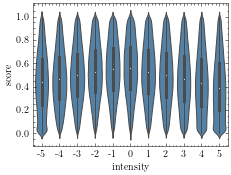

In [40]:
sns.violinplot(data=df.rename(columns={"score_one":"score"}), x="intensity", y="score", color="steelblue")
plt.savefig("analysis/IA/score_one.pdf")